# FMRI Preprocessing Pipeline
Via EEG/FMRI Naturalistic Viewing Dataset (Natview): Resting State

In [34]:
# imports

# connecting to natview dataset
from dotenv import load_dotenv
import os
import glob
from pathlib import Path

# computation
import pandas as pd
import numpy as np

# nilearn and nibabel (neurosci libraries)
import nibabel as nib
from nilearn import datasets
from nilearn import plotting
from nilearn.maskers import NiftiMapsMasker, NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.plotting import find_parcellation_cut_coords

In [13]:
load_dotenv()
DATA_PATH = os.getenv("HPC_NATVIEW_PATH")

In [2]:
# grabbing 22 subjects
rawdata_path = f"{DATA_PATH}/rawdata"
subjects = [f"{rawdata_path}/sub-{i:02d}" for i in range(1, 23)]
test_sub = subjects[0] # subject 01, i.e. 'sub-01'
test_sub

'/Users/maggiezhang/hpc-lab/Projects/Hypergraphsciousness/datasets/natview/rawdata/sub-01'

In [ ]:
# relevant paths
schaefer_timeseries = [f"{DATA_PATH}/derivatives/natview_nki_release/sub-{i:02d}/ses-01/func/sub-{i:02d}_ses-01_task-rest_bold/func_atlas/sub-{i:02d}_ses-01_task-rest_space-MNI152Lin_res-3mm_atlas-Schaefer2018_dens-200parcels7networks_desc-sm0_bold.tsv" for i in range(1, 23)]
test_sub_ts = schaefer_timeseries[0]

bold_mni_path = [f"{DATA_PATH}/derivatives/natview_nki_release/sub-{i:02d}/ses-01/func/sub-{i:02d}_ses-01_task-rest_bold/func_preproc/func_pp_nofilt_sm0.mni152.3mm.nii.gz" for i in range(1, 23)]
test_sub_bold_mni = bold_mni_path[0]

['/Users/maggiezhang/hpc-lab/Projects/Hypergraphsciousness/datasets/natview/derivatives/natview_nki_release/sub-01/ses-01/func/sub-01_ses-01_task-rest_bold/func_preproc/func_pp_nofilt_sm0.mni152.3mm.nii.gz',
 '/Users/maggiezhang/hpc-lab/Projects/Hypergraphsciousness/datasets/natview/derivatives/natview_nki_release/sub-02/ses-01/func/sub-02_ses-01_task-rest_bold/func_preproc/func_pp_nofilt_sm0.mni152.3mm.nii.gz',
 '/Users/maggiezhang/hpc-lab/Projects/Hypergraphsciousness/datasets/natview/derivatives/natview_nki_release/sub-03/ses-01/func/sub-03_ses-01_task-rest_bold/func_preproc/func_pp_nofilt_sm0.mni152.3mm.nii.gz',
 '/Users/maggiezhang/hpc-lab/Projects/Hypergraphsciousness/datasets/natview/derivatives/natview_nki_release/sub-04/ses-01/func/sub-04_ses-01_task-rest_bold/func_preproc/func_pp_nofilt_sm0.mni152.3mm.nii.gz',
 '/Users/maggiezhang/hpc-lab/Projects/Hypergraphsciousness/datasets/natview/derivatives/natview_nki_release/sub-05/ses-01/func/sub-05_ses-01_task-rest_bold/func_preproc

## Visualizing Schaefer Atlas

In [6]:
from nilearn import datasets
from nilearn.plotting import plot_roi, plot_stat_map, show

# Schaefer 2018: 200 ROIs, 7 Yeo networks, 2mm (matches typical fMRI)
schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
atlas_img = schaefer.maps
print(f"Atlas: {atlas_img}")
print(f"Labels:")
for label in schaefer.labels:
    print(label)

[fetch_atlas_schaefer_2018] Dataset found in /Users/maggiezhang/nilearn_data/schaefer_2018
Atlas: /Users/maggiezhang/nilearn_data/schaefer_2018/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.nii.gz
Labels:
Background
7Networks_LH_Vis_1
7Networks_LH_Vis_2
7Networks_LH_Vis_3
7Networks_LH_Vis_4
7Networks_LH_Vis_5
7Networks_LH_Vis_6
7Networks_LH_Vis_7
7Networks_LH_Vis_8
7Networks_LH_Vis_9
7Networks_LH_Vis_10
7Networks_LH_Vis_11
7Networks_LH_Vis_12
7Networks_LH_Vis_13
7Networks_LH_Vis_14
7Networks_LH_SomMot_1
7Networks_LH_SomMot_2
7Networks_LH_SomMot_3
7Networks_LH_SomMot_4
7Networks_LH_SomMot_5
7Networks_LH_SomMot_6
7Networks_LH_SomMot_7
7Networks_LH_SomMot_8
7Networks_LH_SomMot_9
7Networks_LH_SomMot_10
7Networks_LH_SomMot_11
7Networks_LH_SomMot_12
7Networks_LH_SomMot_13
7Networks_LH_SomMot_14
7Networks_LH_SomMot_15
7Networks_LH_SomMot_16
7Networks_LH_DorsAttn_Post_1
7Networks_LH_DorsAttn_Post_2
7Networks_LH_DorsAttn_Post_3
7Networks_LH_DorsAttn_Post_4
7Networks_LH_DorsAttn_Post_5
7

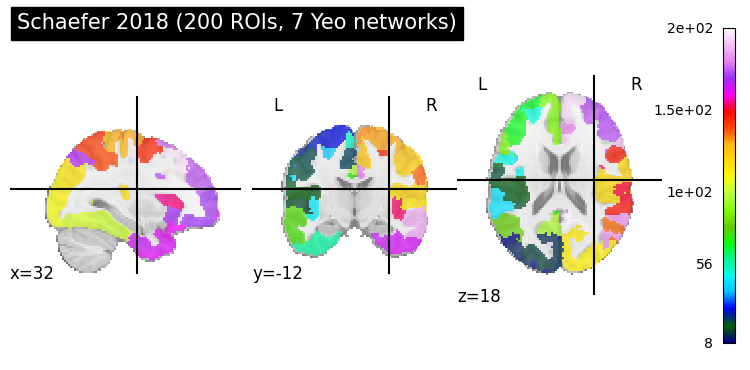

In [7]:
# Plot Schaefer atlas (ROI boundaries)
plot_roi(atlas_img, title="Schaefer 2018 (200 ROIs, 7 Yeo networks)", colorbar=True)
show()

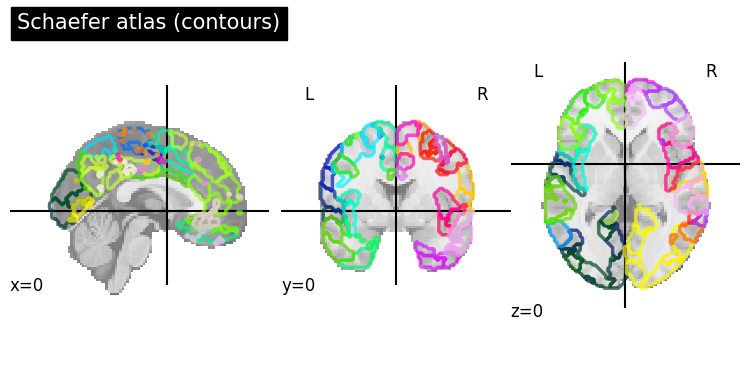

In [8]:
# Plot with contours
plot_roi(atlas_img, view_type="contours", title="Schaefer atlas (contours)")
show()

## Loading Schaefer 2018 TSV with 200 ROI parcellations
For creating correlation matrices.

In [22]:
ts = pd.read_csv(test_sub_ts, sep='\t', header=None)

# file is parcels × timepoints (200 rows × 288 cols), transpose to timepoints × parcels
ts = ts.T
# shape is (288, 200)

# parcel corr mtx 
corr_matrix = ts.corr()
corr_matrix.shape # expect (200, 200)

(200, 200)

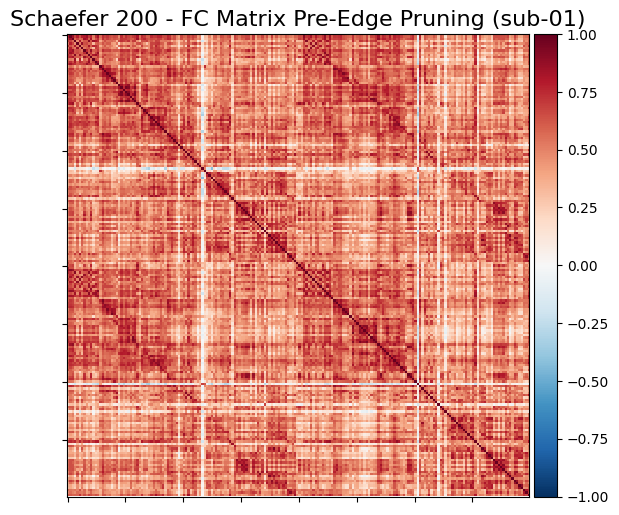

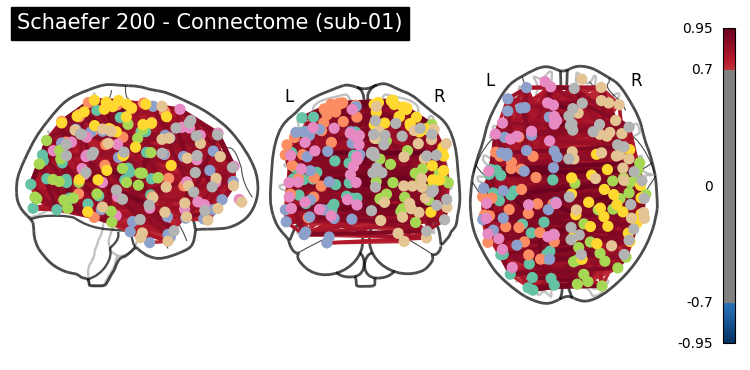

In [ ]:
# corr matrix plot (omit labels)
plotting.plot_matrix(
    corr_matrix.values,
    colorbar=True, vmax=1, vmin=-1,
    title="Schaefer 200 - FC Matrix Pre-Edge Pruning (sub-01)"
)

# find ROI center coordinates from the Schaefer atlas image
coords = find_parcellation_cut_coords(labels_img=atlas_img)

# brain connectome(top 10% strongest edges)
plotting.plot_connectome(
    corr_matrix.values,
    coords,
    edge_threshold="90%",
    colorbar=True,
    title="Schaefer 200 - Connectome (sub-01)"
)
plotting.show()

## Loading select subcortical regions
- Thalamus (L/R hemispheres)
- Caudate (L/R hemispheres)
- Putamen (L/R hemispheres)
- Hippocampus (L/R hemispheres)
- Amygdala (L/R hemispheres)

In [37]:
ho_sub = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm')
# harvard-oxford subcortical matches spaces of schaefer, use to grab subcortical fields

print("Harvard-Oxford subcortical labels:")
for i, label in enumerate(ho_sub.labels):
    print(f"  {i:2d}: {label}")

[fetch_atlas_harvard_oxford] Dataset found in /Users/maggiezhang/nilearn_data/fsl
Harvard-Oxford subcortical labels:
   0: Background
   1: Left Cerebral White Matter
   2: Left Cerebral Cortex
   3: Left Lateral Ventricle
   4: Left Thalamus
   5: Left Caudate
   6: Left Putamen
   7: Left Pallidum
   8: Brain-Stem
   9: Left Hippocampus
  10: Left Amygdala
  11: Left Accumbens
  12: Right Cerebral White Matter
  13: Right Cerebral Cortex
  14: Right Lateral Ventricle
  15: Right Thalamus
  16: Right Caudate
  17: Right Putamen
  18: Right Pallidum
  19: Right Hippocampus
  20: Right Amygdala
  21: Right Accumbens


In [38]:
# target regions and corresponding indices
target_regions = ['Left Thalamus', 'Right Thalamus', 'Left Caudate', 'Right Caudate', 'Left Putamen', 'Right Putamen', 'Left Hippocampus',  'Right Hippocampus', 'Left Amygdala', 'Right Amygdala',]
target_indices = []
for region in target_regions:
    idx = ho_sub.labels.index(region)
    target_indices.append(idx)
print(f"\nTarget label indices: {target_indices}")

atlas_nii = ho_sub.maps
atlas_data = atlas_nii.get_fdata().copy()

# zero out non-target voxels
keep_mask = np.isin(atlas_data, target_indices)
atlas_data[~keep_mask] = 0
subcortical_atlas = nib.Nifti1Image(atlas_data, atlas_nii.affine, atlas_nii.header)

# get subcortical timeseries from MNI-space preprocessed BOLD
masker = NiftiLabelsMasker(labels_img=subcortical_atlas, standardize='zscore_sample', resampling_target='data')  # resample atlas to BOLD 3mm resolution
subcortical_ts = masker.fit_transform(test_sub_bold_mni) # test sub

# mapping extracted columns back to region names
extracted_labels = masker.labels_
subcortical_names = [ho_sub.labels[int(l)] for l in extracted_labels]
print(f"\nSubcortical timeseries shape: {subcortical_ts.shape}")  # (288, 10)
print(f"Extracted regions: {subcortical_names}")

# combine with Schaefer cortical timeseries
# ts is the (288, 200) cortical timeseries from earlier
combined_ts = np.hstack([ts.values, subcortical_ts])  # (288, 210)
combined_labels = list(ts.columns) + subcortical_names
print(f"\nCombined timeseries shape: {combined_ts.shape}")  # (288, 210)

# combined correlation matrix
combined_corr = np.corrcoef(combined_ts, rowvar=False)  # (210, 210)
print(f"Combined correlation matrix shape: {combined_corr.shape}")


Target label indices: [4, 15, 5, 16, 6, 17, 9, 19, 10, 20]

Subcortical timeseries shape: (288, 10)
Extracted regions: ['Background', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Hippocampus', 'Left Amygdala', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Hippocampus', 'Right Amygdala']

Combined timeseries shape: (288, 210)
Combined correlation matrix shape: (210, 210)


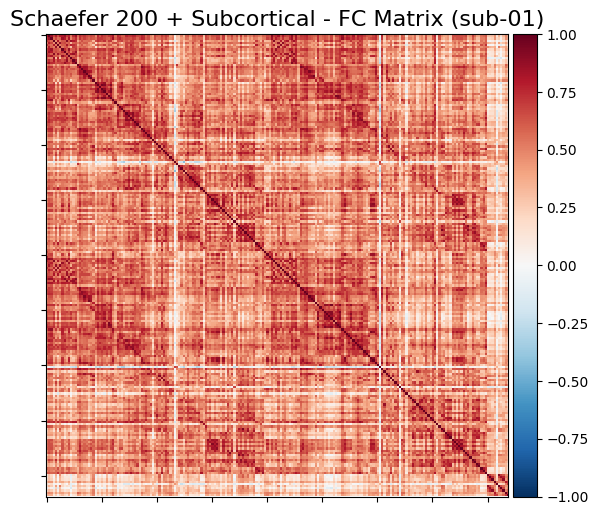

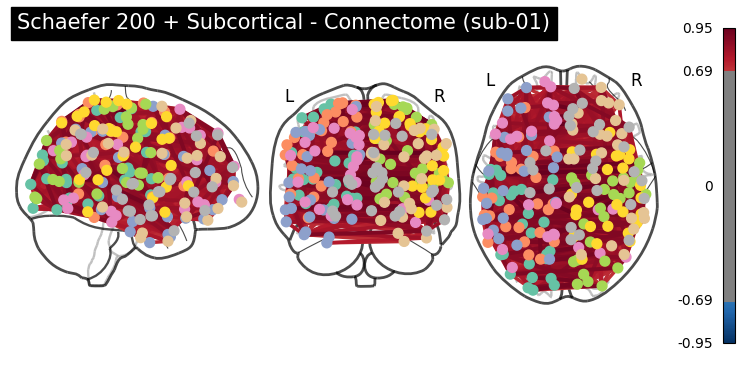

In [36]:
# combined FC matrix (200 cortical + 10 subcortical = 210 ROIs)
plotting.plot_matrix(
    combined_corr,
    colorbar=True, vmax=1, vmin=-1,
    title="Schaefer 200 + Subcortical - FC Matrix (sub-01)"
)

# compute coords: schaefer cortical + subcortical centers
cortical_coords = find_parcellation_cut_coords(labels_img=atlas_img)
subcortical_coords = find_parcellation_cut_coords(labels_img=subcortical_atlas)
combined_coords = np.vstack([cortical_coords, subcortical_coords])

# brain connectome (top 10% strongest edges)
plotting.plot_connectome(
    combined_corr,
    combined_coords,
    edge_threshold="90%",
    colorbar=True,
    title="Schaefer 200 + Subcortical - Connectome (sub-01)"
)
plotting.show()